# English-Spanish Translation: FNet
## Table of Contents
* Overview
* Configuration
* Setup
* Import datasets
* Model Development
* Transalation
* References

In [ ]:
!gdown https://drive.google.com/file/d/1muYCUnsqg8eb8W2nsy94ezCfBPd_hcPx/view?usp=sharing --fuzzy -O data.csv

Downloading...
From: https://drive.google.com/uc?id=1muYCUnsqg8eb8W2nsy94ezCfBPd_hcPx
To: /content/data.csv
100% 8.07M/8.07M [00:00<00:00, 21.9MB/s]


## Configuration

In [ ]:
class Config:
    vocab_size = 15000 # Vocabulary Size
    sequence_length = 20
    batch_size = 64
    validation_split = 0.15
    embed_dim = 256
    latent_dim = 256
    num_heads = 2
    epochs = 10 # Number of Epochs to train
    model_path = "model.h5"
    begin_token = "[start]"
    end_token = "[end]"
    use_pretrained_model = False # Download pretrained Model to speedup the training
config = Config()

## Setup

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import pathlib
import random
import string
import re
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import sklearn
from sklearn.model_selection import train_test_split

## Import datasets

In [ ]:
data = pd.read_csv("data.csv")
data.head()

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [ ]:
data["spanish"] = data["spanish"].apply(lambda item: config.begin_token + " " + item + " " + config.end_token)

In [ ]:
data.head()

,english,spanish
0,Go.,[start] Ve. [end]
1,Go.,[start] Vete. [end]
2,Go.,[start] Vaya. [end]
3,Go.,[start] Váyase. [end]
4,Hi.,[start] Hola. [end]


In [ ]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
print(strip_chars)
def spanish_standardize(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]"%re.escape(strip_chars), "")
english_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length,
)
spanish_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length + 1,
    standardize=spanish_standardize,
)
english_vectorization.adapt(list(data["english"]))
spanish_vectorization.adapt(list(data["spanish"]))

!"#$%&'()*+,-./:;<=>?@\^_`{|}~¿


In [ ]:
def preprocess(english, spanish):
    return (english, spanish[:, :-1]), spanish[:, 1:]
def make_dataset(df, batch_size, mode):
    english = english_vectorization(list(df["english"]))
    spanish = spanish_vectorization(list(df["spanish"]))
    dataset = tf.data.Dataset.from_tensor_slices((english, spanish))
    if mode == "train":
       dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(preprocess)
    dataset = dataset.take(len(df) // batch_size).cache().prefetch(16).repeat(1)
    return dataset

In [ ]:
train, valid = train_test_split(data, test_size=config.validation_split)
train.shape, valid.shape

((101119, 2), (17845, 2))

In [ ]:
train_ds = make_dataset(train, batch_size=config.batch_size, mode="train")
valid_ds = make_dataset(valid, batch_size=config.batch_size, mode="valid")

In [ ]:
for batch in train_ds.take(1):
    print(batch)

((<tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[ 308,  152, 1063, ...,    0,    0,    0],
       [3242,   19,  135, ...,    0,    0,    0],
       [   5,  223, 6584, ...,    0,    0,    0],
       ...,
       [  27,   16,    4, ...,    0,    0,    0],
       [ 159,   28, 2269, ...,    0,    0,    0],
       [   9,   14,   33, ...,    0,    0,    0]])>, <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[   2, 1417,  190, ...,    0,    0,    0],
       [   2, 8972,   23, ...,    0,    0,    0],
       [   2,   28, 1193, ...,    0,    0,    0],
       ...,
       [   2,  160,    5, ...,    0,    0,    0],
       [   2,    1,   36, ...,    0,    0,    0],
       [   2,   20,    7, ...,    0,    0,    0]])>), <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[1417,  190,  134, ...,    0,    0,    0],
       [8972,   23,  481, ...,    0,    0,    0],
       [  28, 1193,   79, ...,    0,    0,    0],
       ...,
       [ 160,    5, 2062, ...,    0,    0,    0],
       [   

## Model Development

### The FNet Encoder

In [ ]:
class FNetEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, **kwargs):
        super(FNetEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs):
        # Casting the inputs to complex64
        inp_complex = tf.cast(inputs, tf.complex64)
        # Projecting the inputs to the frequency domain using FFT2D and
        # extracting the real part of the output
        fft = tf.math.real(tf.signal.fft2d(inp_complex))
        proj_input = self.layernorm_1(inputs + fft)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

### Positional Embedding

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


### FNet Decoder

In [ ]:
class FNetDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(FNetDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask = None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask != None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask
        )

        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask
        )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)

        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

### The FNet Model

In [ ]:
def get_fnet(config):
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(encoder_inputs)
    encoder_outputs = FNetEncoder(config.embed_dim, config.latent_dim)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, config.embed_dim), name="decoder_state_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(decoder_inputs)
    x = FNetDecoder(config.embed_dim, config.latent_dim, config.num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(config.vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name="outputs")

    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    fnet = keras.Model(
        [encoder_inputs, decoder_inputs], decoder_outputs, name="fnet"
    )
    return fnet

In [ ]:
fnet = get_fnet(config)

In [ ]:
fnet.summary()

Model: "fnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, None, 256)            3845120   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                                                                 
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                             

Let's visualize the Model.

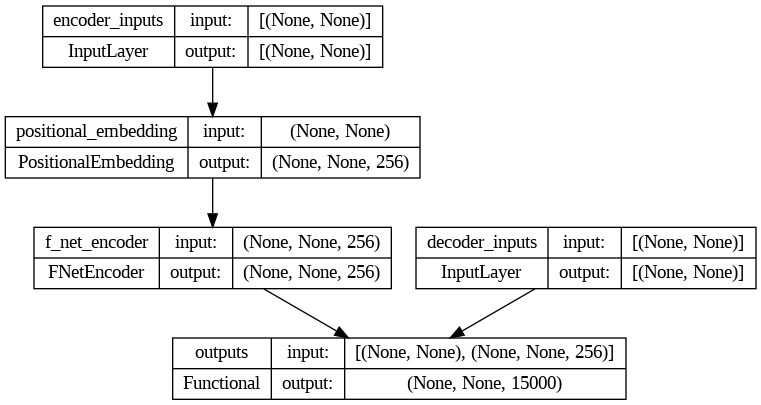

In [ ]:
keras.utils.plot_model(fnet, show_shapes=True)

### Model Training


In [ ]:
fnet.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

I have pretrained the Model. You may use it to speedup the training.

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(config.model_path, save_weights_only=True, save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=5, min_delta=1e-4, min_lr=1e-4)
if config.use_pretrained_model:
    model_path = keras.utils.get_file(config.model_path, "https://github.com/LoniQin/English-Spanish-Transaltion-FNet/raw/main/" + config.model_path)
    fnet.load_weights(model_path)
    fnet.fit(train_ds.take(100), epochs=1, validation_data=valid_ds.take(10), callbacks=[checkpoint, reduce_lr])
else:
    fnet.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[checkpoint, reduce_lr])

Epoch 1/10


1579/1579 [==============================] - 91s 52ms/step - loss: 3.6484 - accuracy: 0.4328 - val_loss: 2.5977 - val_accuracy: 0.5505 - lr: 0.0010
Epoch 2/10
1579/1579 [==============================] - 69s 44ms/step - loss: 2.3963 - accuracy: 0.5713 - val_loss: 2.0753 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 3/10
1579/1579 [==============================] - 69s 44ms/step - loss: 1.8805 - accuracy: 0.6342 - val_loss: 1.8773 - val_accuracy: 0.6453 - lr: 0.0010
Epoch 4/10
1579/1579 [==============================] - 69s 44ms/step - loss: 1.5784 - accuracy: 0.6726 - val_loss: 1.7985 - val_accuracy: 0.6589 - lr: 0.0010
Epoch 5/10
1579/1579 [==============================] - 73s 46ms/step - loss: 1.3769 - accuracy: 0.7020 - val_loss: 1.7810 - val_accuracy: 0.6636 - lr: 0.0010
Epoch 6/10
1579/1579 [==============================] - 69s 44ms/step - loss: 1.2354 - accuracy: 0.7231 - val_loss: 1.7632 - val_accuracy: 0.6692 - lr: 0.0010
Epoch 7/10
1579/1579 [==============================] - 6

## Translation


In [ ]:
spanish_vocab = spanish_vectorization.get_vocabulary()
spanish_index_lookup = dict(zip(range(len(spanish_vocab)), spanish_vocab))
def decode_sequence(fnet, input_sentence):
    tokenized_input_sentence = english_vectorization([input_sentence])
    decoded_sentence = config.begin_token
    for i in range(config.sequence_length):
        tokenized_target_sentence = spanish_vectorization([decoded_sentence])[:, :-1]
        predictions = fnet([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spanish_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == config.end_token:
            break
    return decoded_sentence

In [ ]:
fnet.load_weights(config.model_path)
for i in np.random.choice(len(data), 10):
    item = data.iloc[i]
    translated = decode_sequence(fnet, item["english"])
    print("English:", item["english"])
    print("Spanish:", item["spanish"])
    print("Translated:", translated)

English: You are the best.
Spanish: [start] Usted es la mejor. [end]
Translated: [start] eres lo mejor [end]
English: I can't get my shoes off.
Spanish: [start] No puedo quitarme los zapatos. [end]
Translated: [start] no puedo quitarme los zapatos [end]
English: My grandmother was sent to a hospital in Germany.
Spanish: [start] Enviaron a mi abuela a un hospital en Alemania. [end]
Translated: [start] enviaron a un hospital a mi abuela en alemania [end]
English: How often and how much should I feed my dog?
Spanish: [start] ¿Qué tan a menudo y con cuánto debería alimentar a mi perro? [end]
Translated: [start] qué y cuánto deberían comer a menudo lo [UNK] [end]
English: Show me what you have in your left hand.
Spanish: [start] Muéstrame qué tienes en tu mano izquierda. [end]
Translated: [start] qué me puedes mostrar en la mano [end]
English: You drank too much.
Spanish: [start] Tú tomaste demasiado. [end]
Translated: [start] has bebido demasiado [end]
English: Her skirt is yellow with pol

## References
- [FNet: Mixing Tokens with Fourier Transforms](https://arxiv.org/abs/2105.03824v3)
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762v5)
- [Text Generation using FNet](https://keras.io/examples/nlp/text_generation_fnet/)
